In [1]:
import numpy as np
from env import get_env

In [2]:
rewards_list = []

dataset = {
    "obs" : [],
    "next_obs" : [],
    "target" : [],
    "action" : [],
    "index" : [],
    "loss" : [],
}

for trj_id in range(100):
    env = get_env()
    obs,_ = env.reset(seed=trj_id)
    
    rewards = []
    for i in range(1000):
        if env.include_action:
            action_list = obs[:22]
            obs_list = obs[22:]
            action = env.action_space.sample()
            action = np.clip((obs_list[-1:] - obs_list[-2:-1])*0.07,-1,1)
        else:
            action = np.clip((obs[-1:] - obs[-2:-1])*0.07,-1,1)
        dataset["loss"].append(np.array(env.tributary_rate).reshape(1,-1))
        dataset["obs"].append(np.array(obs)[[0, 1]].reshape(1,-1))
        dataset["target"].append(np.array(obs)[[-1,]].reshape(1,-1))
        dataset["action"].append(np.array(action).reshape(1,-1))
        obs, reward, done, _, info, = env.step(action)
        dataset["next_obs"].append(np.array(obs)[[0, 1]].reshape(1,-1))
        rewards.append(reward)

    dataset["index"].append(len(dataset["obs"]))
    rewards_list.append(np.sum(rewards))
    
for k,v in dataset.items():
    if k != "index":
        dataset[k] = np.concatenate(v) 
    else:
        dataset[k] = np.array(v)
print(np.mean(rewards_list), np.std(rewards_list))

3523.8550706666288 0.0


/home/ubuntu/.local/lib/python3.9/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


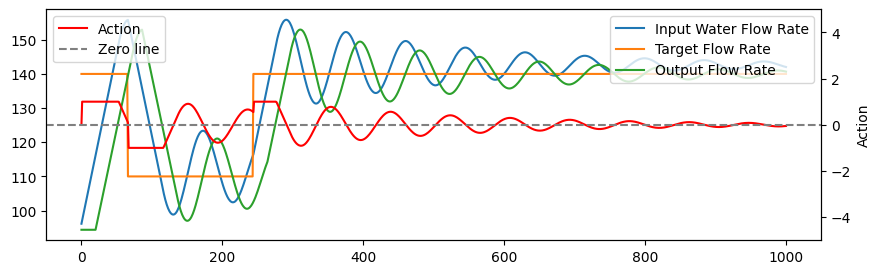

In [4]:
env.render()

In [5]:
data = {
    "obs": [],
    "next_obs": [],
    "delta_obs": [],
    "delta_obs_1": [],
    "delta_obs_2": [],
    "action": [],
    "history_obs": [],
    "next_history_obs": [],
    "target": [],
    "loss": [],
    "hidden_static_obs": [],
    "index": [],
    "trj_id" : [],
}

w = 20

trj_index = 0 
for start_index, end_index in zip([0] + list(dataset["index"]), dataset["index"]):
    trj_index += 1
    obs = dataset["obs"][start_index:end_index]
    next_obs = dataset["next_obs"][start_index:end_index]
    action = dataset["action"][start_index:end_index]
    loss = dataset["loss"][start_index:end_index]
    target = dataset["target"][start_index:end_index]
    
    data["obs"].append(obs[w:])
    data["next_obs"].append(next_obs[w:])
    data["delta_obs"].append(next_obs[w:]-obs[w:])
    data["delta_obs_1"].append(data["delta_obs"][-1][...,:1])
    data["delta_obs_2"].append(data["delta_obs"][-1][...,1:])
    data["action"].append(action[w:])
    data["history_obs"].append(np.concatenate([obs[i:i+w+1].reshape(1,-1) for i in range(len(obs)-w)],axis=0))
    data["next_history_obs"].append(np.concatenate([next_obs[i:i+w+1].reshape(1,-1) for i in range(len(next_obs)-w)],axis=0))
    data["target"].append(target[w:])
    data["loss"].append(loss[w:])
    data["hidden_static_obs"].append(np.concatenate([data["history_obs"][-1][...,:]], axis=1))
    data["index"].append(np.array([980*trj_index,])) 
    
    data["trj_id"].append(np.ones_like(action[w:])*trj_index*1.0) 


for k,v in data.items():
    data[k] = np.concatenate(v, axis=0)
    print(k,data[k].shape)
    
np.savez("./data/pipline.npz", **data)

obs (98000, 2)
next_obs (98000, 2)
delta_obs (98000, 2)
delta_obs_1 (98000, 1)
delta_obs_2 (98000, 1)
action (98000, 1)
history_obs (98000, 42)
next_history_obs (98000, 42)
target (98000, 1)
loss (98000, 1)
hidden_static_obs (98000, 42)
index (100,)
trj_id (98000, 1)
